# Building Image Pairs

In [1]:
import cv2
import numpy as np
import tensorflow
from keras.datasets import mnist
from imutils import build_montages

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
from google.colab.patches import cv2_imshow

In [4]:
# image pairs function

def create_image_pair(images_array, images_label):
  labels = np.unique(images_label)
  num_of_labels = len(np.unique(images_label))
  idx = [np.where(images_label == i)[0] for i in range(num_of_labels)]
  pair_images = []
  label_pair = []
  for i in range(len(images_label)):
    current_image = images_array[i]
    current_label = images_label[i]

    # positive pair
    positive_pair_images = np.random.choice(idx[current_label])
    pair_images.append([current_image,images_array[positive_pair_images]])
    label_pair.append([1])
    # negative pair
    negative_pair_images = np.random.choice(idx[np.random.choice(labels[labels != current_label])])
    pair_images.append([current_image,images_array[negative_pair_images]])
    label_pair.append([0])
  
  return (np.array(pair_images), np.array(label_pair))

In [5]:
pairTrain, labelTrain = create_image_pair(x_train, y_train)
pairTest, labelTest = create_image_pair(x_test, y_test)

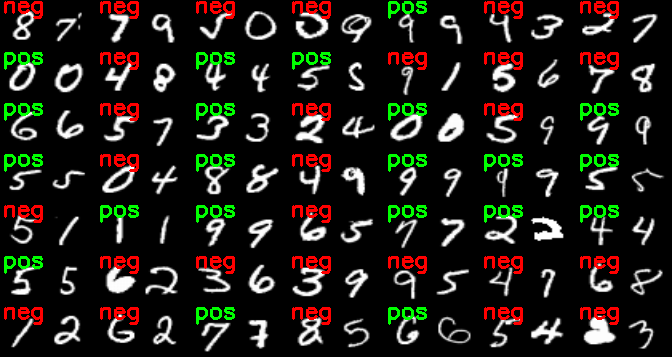

-1

In [6]:
images = []
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	# grab the current image pair and label
	imageA = pairTrain[i][0]
	imageB = pairTrain[i][1]
	label = labelTrain[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with four
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((36, 60), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[4:32, 0:56] = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
	# create a 3-channel RGB image from the grayscale pair, resize
	# it from 60x36 to 96x51 (so we can better see it), and then
	# draw what type of pair it is on the image
	vis = cv2.merge([output] * 3)
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the pair visualization to our list of output images
	images.append(vis)
 
montage = build_montages(images, (96, 51), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)

# Utility Function to compute Distance

In [7]:
import keras.backend as K

In [8]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# Building Siamese Network (Sister Network)

In [9]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Lambda, GlobalAveragePooling2D
from keras.models import Model, Input, Sequential
from keras.optimizers import Adam
from keras.metrics import BinaryCrossentropy

In [10]:
# Feature Extractor model
def build_siamese_model(image_shape, embedding_dim = 48):
  input = Input(shape=image_shape)

  # Perform Convolution and max pooling 1st layer
  x = Conv2D(64, (2,2),padding='same',activation='relu')(input)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)

  # Perform Convolution and max pooling 2nd layer
  x = Conv2D(64, (2,2),padding='same',activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
  pooledOutput = GlobalAveragePooling2D()(x)
  output = Dense(embedding_dim)(pooledOutput)
  # Feature Extractor
  model = Model(inputs=input,outputs=output)

  return model



In [11]:
#Read images
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

pairTrain, labelTrain = create_image_pair(x_train, y_train)
pairTest, labelTest = create_image_pair(x_test, y_test)

In [59]:
image_shape = (28,28,1)
imgA = Input(image_shape)
imgB = Input(image_shape)
feature_extractor = build_siamese_model(image_shape)
featsA = feature_extractor(imgA)
featsB = feature_extractor(imgB)

## Normal Binary Cross Entropy

In [60]:
distance = Lambda(euclidean_distance)([featsA, featsB])
output = Dense(units=1,activation="sigmoid")(distance)

final_model_binary = Model(inputs = [imgA, imgB], outputs=output)

In [62]:
final_model_binary.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [63]:
history = final_model_binary.fit(x = [pairTrain[:,0], pairTrain[:,1]],
                          y = labelTrain[:],
                          batch_size = 64,
                          epochs = 30,
                          validation_data = ([pairTest[:,0],pairTest[:,1]], labelTest[:]),
                          )

Epoch 1/30
1875/1875 [==============================] - 28s 15ms/step - loss: 0.6433 - accuracy: 0.5998 - val_loss: 0.5409 - val_accuracy: 0.7508
Epoch 2/30
1875/1875 [==============================] - 28s 15ms/step - loss: 0.5443 - accuracy: 0.7340 - val_loss: 0.4745 - val_accuracy: 0.7895
Epoch 3/30
1875/1875 [==============================] - 27s 15ms/step - loss: 0.4919 - accuracy: 0.7668 - val_loss: 0.4303 - val_accuracy: 0.8098
Epoch 4/30
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4589 - accuracy: 0.7857 - val_loss: 0.4070 - val_accuracy: 0.8202
Epoch 5/30
1875/1875 [==============================] - 27s 15ms/step - loss: 0.4353 - accuracy: 0.7996 - val_loss: 0.3842 - val_accuracy: 0.8324
Epoch 6/30
1875/1875 [==============================] - 27s 15ms/step - loss: 0.4172 - accuracy: 0.8104 - val_loss: 0.3606 - val_accuracy: 0.8451
Epoch 7/30
1875/1875 [==============================] - 27s 15ms/step - loss: 0.4036 - accuracy: 0.8201 - val_loss: 0.3522 -

In [64]:
final_model_binary.save("model.pb")

INFO:tensorflow:Assets written to: model.pb/assets


## Contrastive Loss

In [65]:
import tensorflow as tf

In [66]:
def contrastive_loss(y, preds, margin=1):
	y = tf.cast(y, preds.dtype)
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	return loss

In [67]:
distance = Lambda(euclidean_distance)([featsA, featsB])

final_model = Model(inputs = [imgA, imgB], outputs=distance)

In [68]:
final_model.compile(loss=contrastive_loss, optimizer="adam")

In [69]:
history = final_model.fit(x = [pairTrain[:,0], pairTrain[:,1]],
                          y = labelTrain[:],
                          batch_size = 64,
                          epochs = 30,
                          validation_data = ([pairTest[:,0],pairTest[:,1]], labelTest[:]),
                          )

Epoch 1/30
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2694 - val_loss: 0.1169
Epoch 2/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1333 - val_loss: 0.1100
Epoch 3/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1266 - val_loss: 0.1106
Epoch 4/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1239 - val_loss: 0.1080
Epoch 5/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1215 - val_loss: 0.1056
Epoch 6/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1208 - val_loss: 0.1046
Epoch 7/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1204 - val_loss: 0.1030
Epoch 8/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1197 - val_loss: 0.1016
Epoch 9/30
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1199 - val_loss: 0.1049
Epoch 10/30
1875/1875 [==============================] - 26s 14m

# Using for prediction

In [78]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [79]:
index = np.random.choice(x_test.shape[0], 10, replace=False)  

In [80]:
for idx_value in index:
  cv2.imwrite(f'{str(idx_value)}.jpeg',x_test[idx_value])

# Comparing the images using the model built

In [81]:
import os
image_list = [dir for dir in os.listdir() if ".jpeg" in dir]

In [82]:
# randomly select 2 image pairs
test_pairs = np.random.choice(image_list,size = (10,2))

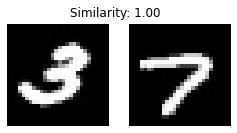

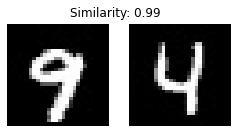

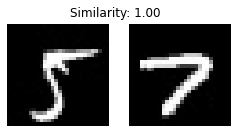

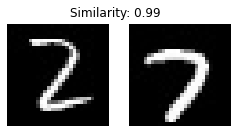

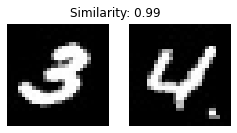

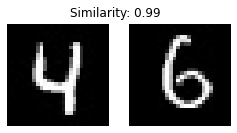

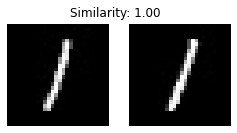

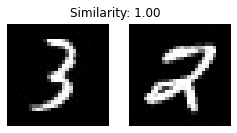

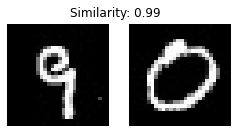

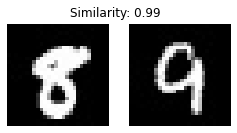

In [83]:
import matplotlib.pyplot as plt
y_pred = []
for pair in test_pairs:
    imgA = cv2.imread(pair[0],cv2.IMREAD_GRAYSCALE)
    imgB = cv2.imread(pair[1],cv2.IMREAD_GRAYSCALE)

    orgA = imgA.copy()
    orgB = imgB.copy()

    imgA = np.expand_dims(imgA, axis=-1)
    imgB = np.expand_dims(imgB, axis=-1)

    imgA = np.expand_dims(imgA, axis=0)
    imgB = np.expand_dims(imgB, axis=0)
    
    imgA = imgA / 255.0
    imgB = imgB / 255.0

    y_pred = final_model_binary.predict([imgA, imgB])[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(y_pred))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(orgA, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orgB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

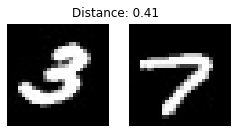

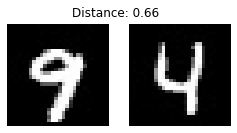

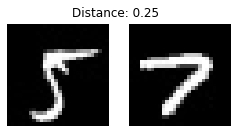

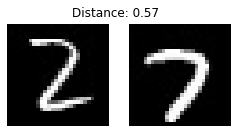

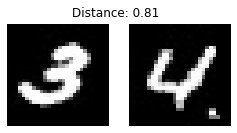

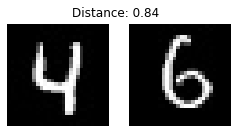

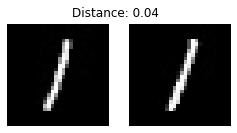

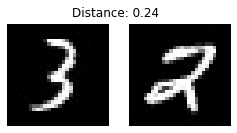

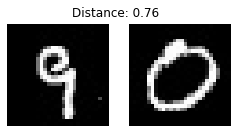

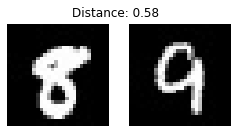

In [84]:
import matplotlib.pyplot as plt
y_pred = []
for pair in test_pairs:
    imgA = cv2.imread(pair[0],cv2.IMREAD_GRAYSCALE)
    imgB = cv2.imread(pair[1],cv2.IMREAD_GRAYSCALE)

    orgA = imgA.copy()
    orgB = imgB.copy()

    imgA = np.expand_dims(imgA, axis=-1)
    imgB = np.expand_dims(imgB, axis=-1)

    imgA = np.expand_dims(imgA, axis=0)
    imgB = np.expand_dims(imgB, axis=0)
    
    imgA = imgA / 255.0
    imgB = imgB / 255.0

    y_pred = final_model.predict([imgA, imgB])[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Distance: {:.2f}".format(y_pred))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(orgA, cmap=plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(orgB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()